In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
df = pd.read_csv('data/heart_hw.csv')


,Unnamed: 0,age,transplant,y
0,1,53,control,0
1,2,43,control,0
2,3,52,control,0
3,4,52,control,0
4,5,54,control,0


In [7]:
# Compute the proportion of survivors in the control group
control_survival_rate = df[df["transplant"] == "control"]["y"].mean()

# Compute the proportion of survivors in the treatment group
treatment_survival_rate = df[df["transplant"] == "treatment"]["y"].mean()

# Compute the average treatment effect (ATE)
ate = treatment_survival_rate - control_survival_rate

# Print the results
print(f"Proportion of survival in control group: {control_survival_rate:.4f}")
print(f"Proportion of survival in treatment group: {treatment_survival_rate:.4f}")
print(f"Average Treatment Effect (ATE): {ate:.4f}")

Proportion of survival in control group: 0.1176
Proportion of survival in treatment group: 0.3478
Average Treatment Effect (ATE): 0.2302


In [9]:
import statsmodels.api as sm
# Regress y on transplant using a linear model
df["transplant_binary"] = (df["transplant"] == "treatment").astype(int)
X = sm.add_constant(df["transplant_binary"])  # Add constant term
y = df["y"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     6.354
Date:                Wed, 05 Mar 2025   Prob (F-statistic):             0.0133
Time:                        14:06:22   Log-Likelihood:                -59.591
No. Observations:                 103   AIC:                             123.2
Df Residuals:                     101   BIC:                             128.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1176      0.07

The regression results align with the values calculated earlier. The intercept (const = 0.1176) represents the survival probability of the control group, which matches the previously calculated proportion of survival in the control group (0.1176). The coefficient on transplant_binary (0.2302) represents the difference in survival probabilities between the treatment and control groups, which matches the Average Treatment Effect (ATE = 0.2302).

The linear regression essentially models survival probability as:
B0=0.1176 (control group's survival probability),
B1=0.2302 (increase in survival probability for the treatment group).
Thus, the regression confirms the earlier calculations, demonstrating that the ATE is the difference in means between the treatment and control groups.

In [10]:
# Regress y on transplant using a linear model
df["transplant_binary"] = (df["transplant"] == "treatment").astype(int)
X = sm.add_constant(df[["transplant_binary", "age"]])  # Add constant term and age variable
y = df["y"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     8.602
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           0.000357
Time:                        14:32:12   Log-Likelihood:                -54.558
No. Observations:                 103   AIC:                             115.1
Df Residuals:                     100   BIC:                             123.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7020      0.19

The intercept increased from 0.1176 in the previous regression (without age) to 0.7020 in the new regression (with age). Previously, the intercept represented the survival probability of the control group (which was directly 0.1176). Now, the intercept represents the estimated survival probability for a patient in the control group when age is 0.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     3.563
Date:                Wed, 05 Mar 2025   Prob (F-statistic):             0.0101
Time:                        17:11:03   Log-Likelihood:                -41.411
No. Observations:                  82   AIC:                             92.82
Df Residuals:                      77   BIC:                             104.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0812      0.461      0.176      0.8

/Users/chloe/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


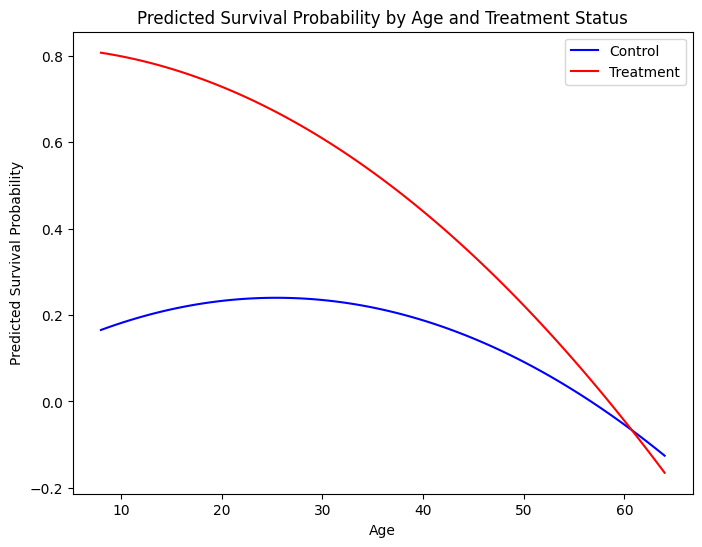

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Create polynomial and interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(df[["age", "transplant_binary"]])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, df["y"], test_size=0.2, random_state=42)

# Fit the model
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Predict survival probabilities by age
age_range = np.linspace(df["age"].min(), df["age"].max(), 100)
transplant_status = np.array([0] * 100 + [1] * 100)  # 0: Control, 1: Treatment
age_expanded = np.concatenate([age_range, age_range])
X_pred = poly.transform(np.column_stack((age_expanded, transplant_status)))
X_pred = sm.add_constant(X_pred)
y_pred = model.predict(X_pred)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(age_range, y_pred[:100], label="Control", color='blue')
plt.plot(age_range, y_pred[100:], label="Treatment", color='red')
plt.xlabel("Age")
plt.ylabel("Predicted Survival Probability")
plt.title("Predicted Survival Probability by Age and Treatment Status")
plt.legend()
plt.show()

The younger they are, those who get treatment are more likely to survive, whereas the older patients who received treatment are less likely. Those who did not receive treatment are more likely to survive if they are between 20 and 35 years old, while both the younger and older ages are less likely. Regardless, almost always is the survival rate better with treatment than without.

If an algorithm like this were used to decide who receives organ transplants, several ethical and practical concerns arise, particularly if the training data contains biases (e.g., past decisions were influenced by race, socioeconomic status, or healthcare access), the model could reinforce and perpetuate these biases. Additionally, historical disparities in medical treatment could lead to unfair scoring that disadvantages certain groups. Complex models with polynomial and interaction terms can be difficult to interpret, and both patients and doctors should understand why a particular individual is given or denied a transplant. Models should be used as a decision-support tool rather than an absolute rule.